In [1]:
from torchvision import datasets
import matplotlib.pyplot as plt
import torch
import random
import math
from tqdm import tqdm
import numpy as np

In [2]:
mnist_train = datasets.MNIST('mnist_data', train=True, download=False)
mnist_test  = datasets.MNIST('mnist_data', train=False, download=False)

In [3]:
def value_to_one_hot(value, num_classes = 10):
    one_hot = [0] * num_classes
    one_hot[value] = 1
    
    return one_hot

In [4]:
train_data = []
valid_data = []
test_data = []

In [5]:
data = []
for i in range(10):
    data.append([])
    
for it in range(len(mnist_train)):
    img, label = mnist_train[it]
    img = torch.tensor(img.getdata()) / 255.0
    
    # plt.figure()
    # plt.imshow(img.reshape(28, 28), cmap='gray')
    # plt.title(f"Label: {label}")
    # plt.show()
    
    label_hot = torch.tensor(value_to_one_hot(label))
    
    data[label].append({'input': img, 'value': label_hot})

for i in range(10):
    random.shuffle(data[i])
    
for i in range(10):
    for_valid = len(data[i]) // 5
    for idx, it in enumerate(data[i]):
        if idx < for_valid:
            valid_data.append(data[i][idx])
        else:
            train_data.append(data[i][idx])

In [6]:
for it in range(len(mnist_test)):
    img, label = mnist_test[it]
    img = torch.tensor(img.getdata()) / 255.0
    
    # plt.figure()
    # plt.imshow(img.reshape(28, 28), cmap='gray')
    # plt.title(f"Label: {label}")
    # plt.show()
    
    label = torch.tensor(value_to_one_hot(label))
    
    test_data.append({'input': img, 'value': label})

In [7]:
print(len(train_data))
print(len(valid_data))
print(len(test_data))

48004
11996
10000


In [8]:
np.savez('./data2.npz', train = train_data, valid = valid_data, test = test_data)

In [2]:
npzfile = np.load('./data2.npz', allow_pickle=True)
train_data = npzfile['train']
valid_data = npzfile['valid']
test_data = npzfile['test']

In [3]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def compute_y1(w, x, b):
    z = x @ w + b
    return sigmoid(z)

def train_perceptron(x, w, b, y_true, lr):
    y_pred = compute_y1(w, x, b)
    
    err = y_true - y_pred
    
    w = w + lr * (x.T @ err)
    b = b + lr * err.mean(axis = 0)
    
    return w, b

In [4]:
batch = 64
w = torch.rand((784, 10))
b = torch.rand((10,))
init_lr = 0.1
epochs = 500

In [5]:
acc = 0
for it in test_data:
    x = it['input'].unsqueeze(0)
    y = it['value'].unsqueeze(0)
    
    y_pred = compute_y1(w, x, b)
    
    if y_pred.argmax() == y.argmax():
        acc += 1
print(acc / len(test_data))

0.0984


In [6]:
best_w = w
best_b = b
best_acc = 0.0
metric_val = []

In [7]:
def poly_lr(ep, max_ep, initial_lr, exponent=0.9):
    return initial_lr * (1 - ep / max_ep)**exponent

In [8]:
for epoch in tqdm(range(epochs)):
    lr = poly_lr(epoch, epochs, init_lr, 0.9)
    
    random.shuffle(train_data)
    
    iteratii = len(train_data) // batch
    for it in range(iteratii):
        x = []
        y = []
        for idx in range(batch * it, batch * (it + 1)):
            x.append(torch.tensor(train_data[idx]['input']))
            y.append(torch.tensor(train_data[idx]['value']))
        
        x = torch.stack(x, dim=0)
        y = torch.stack(y, dim=0)
        
        w, b = train_perceptron(x, w, b, y, lr)
        
    acc = 0
    for it in valid_data:
        x = it['input'].unsqueeze(0)
        y = it['value'].unsqueeze(0)

        y_pred = compute_y1(w, x, b)

        if y_pred.argmax() == y.argmax():
            acc += 1
    
    acc /= len(valid_data)
    metric_val.append(acc)
    
    if acc > best_acc:
        best_acc = acc
        best_w = w
        best_b = b

  0%|                                                                                                               | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_804159/2951456170.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x.append(torch.tensor(train_data[idx]['input']))
/tmp/ipykernel_804159/2951456170.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y.append(torch.tensor(train_data[idx]['value']))
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [11:28<00:00,  1.38s/it]


In [9]:
print(best_acc)

0.9072190730243415


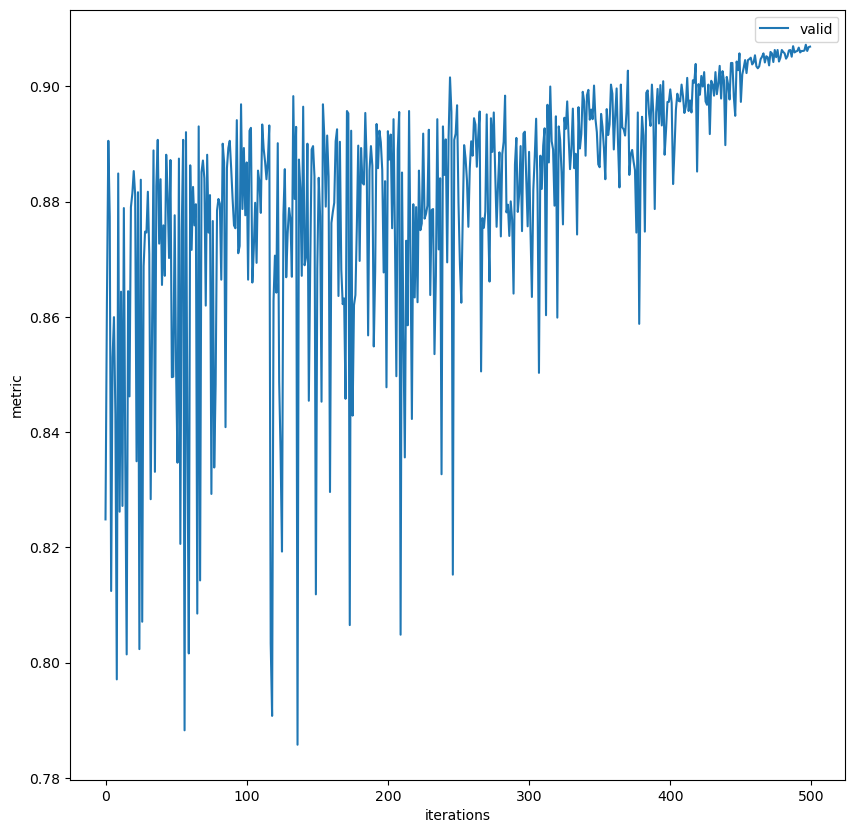

In [10]:
plt.figure(figsize=(10,10))
plt.plot(metric_val, label='valid')
plt.xlabel("iterations")
plt.ylabel('metric')
plt.legend()
plt.show()

In [11]:
acc = 0
for it in test_data:
    x = it['input'].unsqueeze(0)
    y = it['value'].unsqueeze(0)
    
    y_pred = compute_y1(best_w, x, best_b)
    
    if y_pred.argmax() == y.argmax():
        acc += 1
print(acc / len(test_data))

0.9135


In [12]:
np.savez('./model.npz', w = best_w, b = best_b)